In [38]:
import os
import torch
import itertools
import numpy as np
import rasterio as rio
from typing import Union
import matplotlib.pyplot as plt
from basicsr.archs.rrdbnet_arch import RRDBNet

weights_file = "../weights/satlas/esrgan_1S2.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the model
srmodel = RRDBNet(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_block=23,
    num_grow_ch=32,
    scale=4
).to(device)

# Setup the weights
state_dict = torch.load(weights_file)
srmodel.load_state_dict(state_dict['params_ema'])
srmodel.eval()

# no gradients
for param in srmodel.parameters():
    param.requires_grad = False

In [55]:
image = rio.open(f'../data/input/{path}').read().squeeze()

In [57]:
image = (image - image.min()) / (image.max() - image.min())

array([[[2242., 2198., 2192., ..., 1580., 1558., 1586.],
        [2009., 2058., 2010., ..., 1588., 1567., 1617.],
        [1789., 1775., 1766., ..., 1526., 1532., 1619.],
        ...,
        [2148., 2076., 1920., ..., 1728., 1720., 1768.],
        [1781., 1688., 1602., ..., 1722., 1759., 1778.],
        [1593., 1486., 1593., ..., 1706., 1794., 1814.]],

       [[2178., 2144., 2138., ..., 1795., 1824., 1825.],
        [1996., 2044., 2002., ..., 1820., 1856., 1858.],
        [1766., 1817., 1816., ..., 1802., 1833., 1913.],
        ...,
        [2086., 2024., 1910., ..., 1785., 1770., 1746.],
        [1762., 1749., 1644., ..., 1772., 1771., 1776.],
        [1550., 1542., 1596., ..., 1731., 1760., 1890.]],

       [[2066., 1995., 1913., ..., 1380., 1410., 1409.],
        [1697., 1783., 1800., ..., 1396., 1418., 1411.],
        [1593., 1529., 1514., ..., 1363., 1400., 1420.],
        ...,
        [1892., 1827., 1657., ..., 1594., 1595., 1552.],
        [1539., 1456., 1372., ..., 1562., 151

In [75]:
import cv2

In [76]:
def make_satlas(in_path, out_path):
    cropsize = 32
    overlap = 0

    image = rio.open(in_path).read().squeeze()
    image = (image - image.min()) / (image.max() - image.min())

    # lr = torch.from_numpy(image[[3, 2, 1]]/3558).float().to(device).clamp(0, 1)
    # lr = torch.from_numpy(image[0:3] / 3558).float().to(device).clamp(0, 1)
    lr = torch.from_numpy(image[0:3]).float().to(device).clamp(0, 1)
    tshp = lr.shape
    xmn, xmx, ymn, ymx = (0, tshp[1], 0, tshp[2])

    xrange = np.arange(xmn, xmx, (cropsize - overlap))
    yrange = np.arange(ymn, ymx, (cropsize - overlap))

    xrange[xrange < 0] = 0
    yrange[yrange < 0] = 0

    mrs = list(itertools.product(xrange, yrange))
    sr_img = torch.zeros(3, tshp[1]*4, tshp[2]*4)

    for x, y in mrs:
        crop = lr[:, x:x+cropsize, y:y+cropsize]
        sr_crop = srmodel(crop[None])[0]
        sr_img[:, x*4:(x+cropsize)*4, y*4:(y+cropsize)*4] = sr_crop
    
    # fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    # ax[0].imshow(np.moveaxis(image, 0, -1)*2.5)
    # ax[1].imshow(np.moveaxis(sr_img.numpy(), 0, -1))

    # Convert the super-resolved image to a numpy array
    sr_img_np = sr_img.numpy()
    sr_img_np = np.moveaxis(sr_img_np, 0, -1)
    sr_img_cv2 = (sr_img_np * 255).astype(np.uint8)
    yuv_img = cv2.cvtColor(sr_img_cv2, cv2.COLOR_RGB2YUV)
    yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])
    equalized_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

    # Plot the original and adjusted images
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    ax[0].imshow(np.moveaxis(image, 0, -1) * 2.5)
    ax[1].imshow(equalized_img)

    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
    # plt.savefig(out_path)

In [103]:
def make_satlas(in_path, out_path):
    cropsize = 16
    overlap = 4  # Cambia el solapamiento para blending

    # Leer y normalizar la imagen completa
    image = rio.open(in_path).read().squeeze()
    image = (image - image.min()) / (image.max() - image.min())

    # Crear el tensor de la imagen para PyTorch
    lr = torch.from_numpy(image[[2,1,0]]).float().to(device).clamp(0, 1)
    tshp = lr.shape
    xmn, xmx, ymn, ymx = (0, tshp[1], 0, tshp[2])

    xrange = np.arange(xmn, xmx, (cropsize - overlap))
    yrange = np.arange(ymn, ymx, (cropsize - overlap))

    # Inicializar la imagen super-resuelta y el contador para blending, y mover a GPU
    sr_img = torch.zeros(3, tshp[1]*4, tshp[2]*4, device=device)
    count_map = torch.zeros(3, tshp[1]*4, tshp[2]*4, device=device)

    for x, y in itertools.product(xrange, yrange):
        crop = lr[:, x:x+cropsize, y:y+cropsize]
        sr_crop = srmodel(crop[None])[0]

        # Determinar los índices donde se insertará el crop escalado
        x_start, x_end = x*4, (x+cropsize)*4
        y_start, y_end = y*4, (y+cropsize)*4

        # Añadir el crop a la imagen final
        sr_img[:, x_start:x_end, y_start:y_end] += sr_crop
        count_map[:, x_start:x_end, y_start:y_end] += 1

    # Evitar divisiones por cero en el mapa de conteo
    count_map[count_map == 0] = 1

    # Promediar las áreas solapadas
    sr_img /= count_map

    # Convertir la imagen a numpy para ecualizar histograma
    sr_img_np = sr_img.cpu().numpy()  # Mover a CPU antes de convertir a numpy
    sr_img_np = np.moveaxis(sr_img_np, 0, -1)
    sr_img_cv2 = (sr_img_np * 255).astype(np.uint8)

    # Ajuste de histograma
    yuv_img = cv2.cvtColor(sr_img_cv2, cv2.COLOR_RGB2YUV)
    yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])
    equalized_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

    # Mostrar los resultados
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    ax[0].imshow(np.moveaxis(image, 0, -1) * 2.5)
    ax[1].imshow(sr_img_cv2)

    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


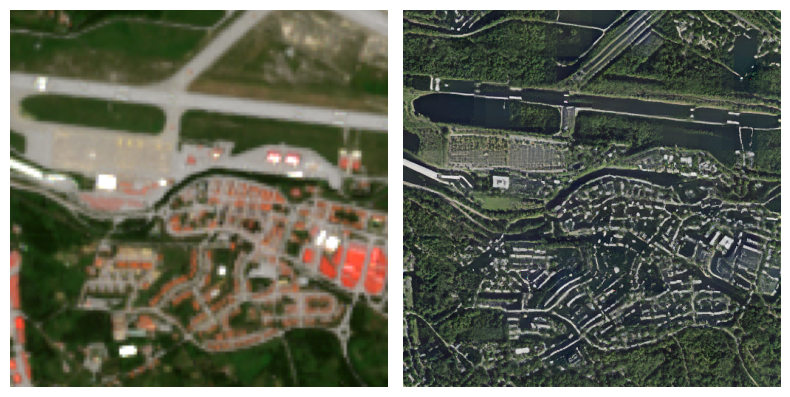

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


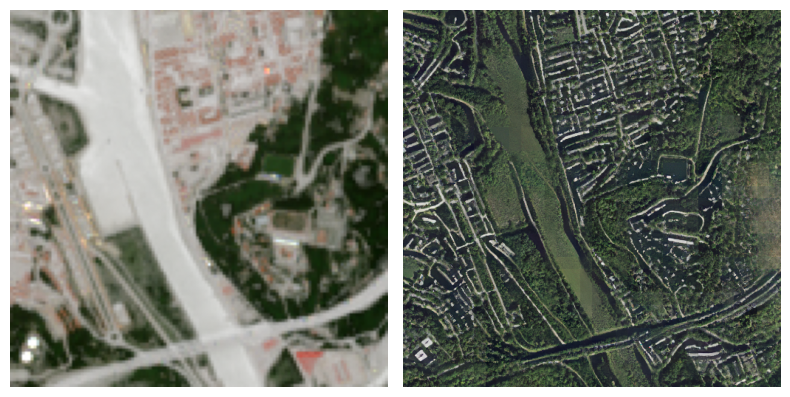

In [104]:
paths = os.listdir("../data/input")
for path in paths[:2]:
    make_satlas(f'../data/input/{path}', f'../data/out_satlas/{path.replace(".tif", ".png")}')

In [ ]:
def make_superimage(in_path, out_path):
    # Load the image
    image = rio.open(in_path).read().squeeze()
    image = image[0:3] / 10000
    image_torch = torch.from_numpy(image).float()

    with torch.no_grad():
        sr_img = srmodel(image_torch[None]).squeeze()

    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    ax[0].imshow(np.moveaxis(image, 0, -1)*2.5)
    ax[1].imshow(np.moveaxis(sr_img.numpy(), 0, -1)*2.5)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    # Save the figure
    # plt.show()
    plt.savefig(out_path)
    
paths = os.listdir('../data/input')
for path in paths:
    make_superimage(f'../data/input/{path}', f'../data/out_superimage/{path.replace(".tif", ".png")}')